# LIBRARIES

In [1]:
import pickle
from Environment import Environment
from UserCat import UserCat
from Product import Product
from Greedy_optimizer import *
import numpy as np
import matplotlib.pyplot as plt


# TESTING of ENVIRONMENT.py

In [2]:
users=[]
products=[]

nameofproduct= [ #name of products
    "Calabazas",
    "Hinojo",
    "Sesamo",
    "Girasol",
    "Amapola"
]

prices=[[4., 6, 7, 8],
    [9., 13, 17, 21],
    [18., 20, 22, 24],
    [24., 26, 28, 30],
    [33., 35, 37, 39]]
#1-2 di delta, Con sovrapposizione

cost=[2,4.5,9,14,17]

#sarebbe interessante anche prendere da file il tutto così da cambiare tutto più facilmente
#calcolo i margini dai cost mi sembra più sensato e anche più veloce se dobbiamo cambiare continuamente

cost2 = np.tile(np.array([cost]).transpose(), (1, 4))
margins = np.array(prices)-cost2

Secondary_dict={           # Propongo i prodotti più simili a quello mostrato --> problemino: 2 viene mostrato quasi sempre
    "Calabazas": [1,2],
    "Hinojo": [0,2],
    "Sesamo": [1,3],
    "Girasol": [2,4],
    "Amapola": [2,3]
}

res_price_params = {
    "shape": 150,  # media è shape*scale, la varianza è shape*scale^2
    "scale": 0.2,
    "max" : 60,
    "min" : 5
}

np.random.seed(1)
probabilities = [[0, 0.3, 0.2, 0, 0],
                 [0.3, 0, 0.3, 0, 0],
                 [0, 0.2, 0, 0.4, 0],
                 [0, 0, 0.2, 0, 0.4],
                 [0, 0, 0.3, 0.3, 0]]
probabilities = np.matrix(probabilities)


alphas=[1/5, 1/5, 1/5, 1/5, 1/5] 
# per ora li generiamo così, tutti uguali -> devo generare 3 diversi vettori alpha

poisson_lambda = 0.7
#=valore atteso del numero di prodotti acquistati (specifico per prodotto)...non dipende dal
#prodotto oltre che dallo user che dal tipo di user che

# p_users = [4/9, 3/9, 2/9] #probabilità di essere un tipo di utente-> da cambiare
p_users = [1]

lambda_q = 0.5 #just my idea of lambda
#possiamo stimarlo con i dati passati provenienti dal sito -> vino tot è stato comprato 15 volte

#proviamo a pensare, ha senso vederlo come coppia? categoria-prodotto? Avrei 3 categorie *5 prodotti-> 15 lambda diversi
# ^^ Andre: secondo me ha senso avere 3 lambda_q diversi per categoria MA non per prodotto. La probabilità di continuare
#           a guardare secondo me dipende dall'utente e non dal prodotto

for i in range (5):
    products.append(Product(prices[i], i, nameofproduct[i],margins[i]))

# for i in range(3):
users.append(UserCat(alphas, res_price_params, poisson_lambda, probabilities))

Env = Environment(users, products,  lambda_q, Secondary_dict, p_users)


# Expected Reward test

In [3]:
# ENVIRONMENT
users=[]
products=[]

nameofproduct= [ #name of products
    "Calabazas",
    "Hinojo",
    "Sesamo",
    "Girasol"
]

prices=[[4., 6, 7, 8],
    [9., 13, 17, 21],
    [18., 20, 22, 24],
    [24., 26, 28, 30]]
#1-2 di delta, Con sovrapposizione

cost=[2,4.5,9,14]

#sarebbe interessante anche prendere da file il tutto così da cambiare tutto più facilmente
#calcolo i margini dai cost mi sembra più sensato e anche più veloce se dobbiamo cambiare continuamente

cost2 = np.tile(np.array([cost]).transpose(), (1, 4))
margins = np.array(prices)-cost2

Secondary_dict={           # Propongo i prodotti più simili a quello mostrato --> problemino: 2 viene mostrato quasi sempre
    "Calabazas": [1,2],
    "Hinojo": [0,2],
    "Sesamo": [1,3],
    "Girasol": [1,2]
}

res_price_params = {
    "shape": 150,  # media è shape*scale, la varianza è shape*scale^2
    "scale": 0.2,
    "max" : 60,
    "min" : 5
}

np.random.seed(1)
probabilities = [[0, 0.3, 0.2, 0],
                 [0.3, 0, 0.3, 0],
                 [0, 0.2, 0, 0.4],
                 [0, 0.2, 0.3, 0]]
probabilities = np.matrix(probabilities)


alphas=[1/5, 1/5, 1/5, 1/5, 1/5] 
# per ora li generiamo così, tutti uguali -> devo generare 3 diversi vettori alpha

poisson_lambda = 0.7
#=valore atteso del numero di prodotti acquistati (specifico per prodotto)...non dipende dal
#prodotto oltre che dallo user che dal tipo di user che

# p_users = [4/9, 3/9, 2/9] #probabilità di essere un tipo di utente-> da cambiare
p_users = [1]

lambda_q = 0.5 #just my idea of lambda
#possiamo stimarlo con i dati passati provenienti dal sito -> vino tot è stato comprato 15 volte

#proviamo a pensare, ha senso vederlo come coppia? categoria-prodotto? Avrei 3 categorie *5 prodotti-> 15 lambda diversi
# ^^ Andre: secondo me ha senso avere 3 lambda_q diversi per categoria MA non per prodotto. La probabilità di continuare
#           a guardare secondo me dipende dall'utente e non dal prodotto

for i in range (4):
    products.append(Product(prices[i], i, nameofproduct[i],margins[i]))

# for i in range(3):
users.append(UserCat(alphas, res_price_params, poisson_lambda, probabilities))

Env_prova = Environment(users, products,  lambda_q, Secondary_dict, p_users)

# CASI POSSIBILI
# Guardare documento word su trello nella scheda TEST EXPECTED REWARD
# 0 a): b0*(1-q01)*(1-q02)*m0 
# 0 b) : b0*q01*(1-b1)*[(1-q02)+q02*(1-b2)]*m0
# 0-1 a) :b0*q01*b1*q12*(1-b2)*[m0+m1]
# 0-1 b): b0*q01*b1*(1-q12)*[(1-q02)+q02*(1-b2)]*[m0+m1]
# 0-2 a): b0*(1-q01)*q02*b2*{(1-q21)*(1-q23)+ q21*(1-b1)*[(1-q23) + q23*(1-b3)]}*[m0+m2]
# 0-2 b) : b0*q01*(1-b1)*q02*b2*[q23*(1-b3)+(1-q23)]* [m0+m2]
# 0-1-2 a): b0*q01*b1*q12*b2*[q23*(1-b3)*(1-q23)] *[m0+m1+m2]
# 0-1-2 b): b0*q01*b1*(1-q12)*(q02)*b2*[q23*(1-b3)*(1-q23)] *[m0+m1+m2]
# 0-1-2-3 a) : b0*q01*b1*q12*b2*q23*b3*[m0+m1+m2+m3]
# 0-1-2-3 b) : b0*q01*b1*(1-q12)*q02*b2*q23*b3*[m0+m1+m2+m3]
# 0-2-3 a) : b0*q01*(1-b1)*q02*b2*q23*b3*[m0+m2+m3]
# 0-2-3 b) : b0*(1-q01)*q02*b2*q21*(1-b1)*q23*b3*[m0+m2+m3]
# 0-2-3 c) : b0*(1-q01)*q02*b2*(1-q21)*q23*b3*[q31*(1-b1)+(1-q31)] *[m0+m2+m3]
# 0-2-3-1 : b0*(1-q01) *q02*b2*q23*b3*q31*b1[m0+m1+m2+m3]
# 0-2-1 : b0*(1-q01)*q02*b2*q12*b1*[q23*(1-b23)+(1-q23)]*[m0+m1+m2]

# definisco i valori teorici
b0 = Env_prova.theoretical_values["conversion_rates"][0][0][0]
b1 = Env_prova.theoretical_values["conversion_rates"][0][1][0]
b2 = Env_prova.theoretical_values["conversion_rates"][0][2][0]
b3 = Env_prova.theoretical_values["conversion_rates"][0][3][0]

q01 = Env_prova.theoretical_values["graph_weights"][0][0,1]
q02 = lambda_q * Env_prova.theoretical_values["graph_weights"][0][0,2]
q10 = Env_prova.theoretical_values["graph_weights"][0][1,0]
q12 = lambda_q * Env_prova.theoretical_values["graph_weights"][0][1,2]
q21 = Env_prova.theoretical_values["graph_weights"][0][2,1]
q23 = lambda_q * Env_prova.theoretical_values["graph_weights"][0][2,3]
q31 = Env_prova.theoretical_values["graph_weights"][0][3,1]
q32 = lambda_q * Env_prova.theoretical_values["graph_weights"][0][3,2]

m0 = margins[0,0] * Env_prova.theoretical_values["n_prod_sold"][0]
m1 = margins[1,0] * Env_prova.theoretical_values["n_prod_sold"][0]
m2 = margins[2,0] * Env_prova.theoretical_values["n_prod_sold"][0]
m3 = margins[3,0] * Env_prova.theoretical_values["n_prod_sold"][0]

theoretical_reward = ( b0*(1-q01)*(1-q02)*m0 + b0*q01*(1-b1)*((1-q02)+q02*(1-b2))*m0 + b0*q01*b1*q12*(1-b2)*(m0+m1) +
b0*q01*b1*(1-q12)*((1-q02)+q02*(1-b2))*(m0+m1) + b0*(1-q01)*q02*b2*((1-q21)*(1-q23)+ q21*(1-b1)*((1-q23) + q23*(1-b3)))*(m0+m2) +
b0*q01*(1-b1)*q02*b2*(q23*(1-b3)+(1-q23))* (m0+m2) + b0*q01*b1*q12*b2*(q23*(1-b3)*(1-q23)) *(m0+m1+m2) + 
b0*q01*b1*(1-q12)*(q02)*b2*(q23*(1-b3)*(1-q23)) *(m0+m1+m2) + b0*q01*b1*q12*b2*q23*b3*(m0+m1+m2+m3) +
b0*q01*b1*(1-q12)*q02*b2*q23*b3*(m0+m1+m2+m3) + b0*(1-q01)*q02*b2*q21*(1-b1)*q23*b3*(m0+m2+m3) +
b0*(1-q01)*q02*b2*(1-q21)*q23*b3*(q31*(1-b1)+(1-q31))*(m0+m2+m3) + b0*(1-q01) *q02*b2*q23*b3*q31*b1*(m0+m1+m2+m3)+
b0*(1-q01)*q02*b2*q12*b1*(q23*(1-b3)+(1-q23))*(m0+m1+m2) )

product = products[0]
price_combination = [0, 0, 0, 0]
user_index = 0

Env_prova.expected_reward(price_combination)

algo_reward = Env_prova.product_reward(product, [], [0], [Product([], -1, "null", [])], price_combination, user_index)
print("theoretical reward :", theoretical_reward)
print("environment reward :", algo_reward)

theoretical reward : 6.786367931533913
environment reward : 8.015746130857606


In [21]:
Env_prova.theoretical_values["conversion_rates"][0][0][0]

1.0

In [3]:
probabilities

matrix([[0. , 0.3, 0.2, 0. , 0. ],
        [0.3, 0. , 0.3, 0. , 0. ],
        [0. , 0.2, 0. , 0.4, 0. ],
        [0. , 0. , 0.2, 0. , 0.4],
        [0. , 0. , 0.3, 0.3, 0. ]])

In [4]:
Env.optimal_reward()

(24.8022023993209, [3, 3, 3, 1, 0])

In [5]:
Env.expected_reward(price_combination = [3, 3, 3, 1, 0])

24.8022023993209

In [5]:
Env.theoretical_values["conversion_rates"]

[[[1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 0.9999999998752992, 0.9999789309305123],
  [0.9999999952046976,
   0.999998115789534,
   0.999830884279656,
   0.9954365586958488],
  [0.9954365586958488,
   0.953934455985104,
   0.790456376081393,
   0.4891417702506403],
  [0.11253650959801176,
   0.024730797264387316,
   0.003591106878226058,
   0.00035361134176770115]]]

In [4]:
a = Env.simulate_day(10000, [1,1,1,0,1], ["conversion_rates"])
a['CR_vector']


array([0.99999818, 0.        , 0.99975616, 0.99106274, 0.02153982])

# Greedy Algorithm Test

In [9]:
greedy_optimizer = Greedy_optimizer(Env)
greedy_optimizer.run()

{'combination': [3, 3, 3, 1, 0], 'expected_reward': 24.801998788989273}

# STEP 3 : Uncertain Convertion Rates

In [10]:
from step3_learner import TS_learner3

In [11]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta = [a, b]
learner = TS_learner3(initial_beta, Env)

In [12]:
n_runs = 100
daily_users = 200
n_days = 300

for i in range(n_runs) :
    learner.run(n_days, daily_users)

opt_reward = learner.opt_reward
collected_rewards = learner.reward_history

- ## Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [13]:
with open('step3_rewards', 'wb') as f: 
    pickle.dump(collected_rewards, f)

- ## Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [12]:
with open('step3_rewards', 'rb') as f: 
    collected_rewards = pickle.load(f)

- ## Cumulative Regret Plot

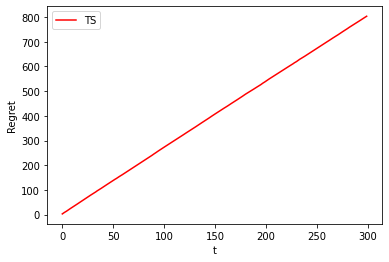

In [14]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt_reward - collected_rewards, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g') #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

- ## Standard Deviation Plot

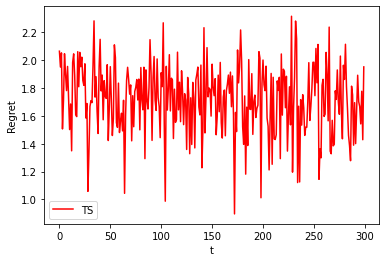

In [15]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.std(opt_reward - collected_rewards, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

### We are now computing the (theoretical) expected reward from each arm in the history (for each "experiment")
#### In any case I think it is more correct collecting and store the reward collected for any iteration of the algorithm inside a class attribute of the learner (as in the exercitation code). In this way we can also deal easier with more complex cases where the uncertain value are also the alpha ratios, n_prod and graph weights different from none, and simply manage also the case of abrupt changes, or cases of code/logic/numeric changes in the environment.

In [33]:
Env.theoretical_values["conversion_rates"][0]

[[1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 0.9999999998752992, 0.9999789309305123],
 [0.9999999952046976,
  0.999998115789534,
  0.999830884279656,
  0.9954365586958488],
 [0.9954365586958488,
  0.953934455985104,
  0.790456376081393,
  0.4891417702506403],
 [0.11253650959801176,
  0.024730797264387316,
  0.003591106878226058,
  0.00035361134176770115]]

In [32]:
Env.simulate_day(200, [1,1,1,1,0], ["conversion_rates", "alpha_ratios"])


{'CR_vector': array([0.99980004, 0.99990742, 0.99967752, 0.94976256, 0.14282314]),
 'alpha_ratios': array([0.23, 0.37, 0.  , 0.2 , 0.2 ])}

In [16]:
(opt_reward - collected_rewards)[1][-40:]

array([3.0247055 , 0.46701452, 2.46800751, 2.46800751, 2.8209373 ,
       2.00087835, 0.        , 2.00087835, 2.46800751, 2.46800751,
       3.86939499, 2.46800751, 0.46701452, 0.39866188, 2.58754688,
       3.0247055 , 3.49183471, 2.46800751, 2.00087835, 2.46800751,
       2.46800751, 2.00087835, 2.00087835, 2.46800751, 3.0247055 ,
       0.46701452, 3.86939499, 2.00087835, 2.46800751, 2.46800751,
       2.00087835, 0.        , 8.3670504 , 2.46800751, 2.58754688,
       2.46800751, 2.46800751, 2.00087835, 2.46800751, 0.46701452])